In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import eda_helper_functions
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
import sklearn

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Taking the raw data
flights = pd.read_csv("../data/flight_price.csv")
flights.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
# Removing the duplicates from the data 
remove_index = flights[flights.duplicated()].index
flights.drop(index = remove_index,inplace = True)

In [5]:
# Descrption of the dataset

# <class 'pandas.core.frame.DataFrame'>
# Index: 10682 entries, 0 to 10682
# Data columns (total 9 columns):
#  #   Column           Non-Null Count  Dtype         
# ---  ------           --------------  -----         
#  0   Airline          10682 non-null  object        
#  1   Date_of_Journey  10682 non-null  datetime64[ns]
#  2   Source           10682 non-null  object        
#  3   Destination      10682 non-null  object        
#  4   Dep_Time         10682 non-null  object        
#  5   Duration         10682 non-null  object        
#  6   Total_Stops      10682 non-null  int64         
#  7   Additional_Info  10682 non-null  object        
#  8   Price            10682 non-null  int64         
# dtypes: datetime64[ns](1), int64(2), object(6)
# memory usage: 834.5+ KB

In [6]:
# Function to change to the numercical stop

def change_to_numerical_stops(value):
    if(value == 'non-stop'):
        return 0
    elif (value == '1 stop'):
        return 1
    elif (value == '2 stops'):
        return 2
    elif (value == '3 stops'):
        return 3
    else:
        return 4

In [7]:
# Converting the duration to minutes

def change_duration_type(value):
    parts = value.split()
    if(len(parts) == 1):
        if 'h' in parts[0]:
            time = int(parts[0].replace('h','')) * 60
            return time
        else:
            time = int(parts[0].replace('m',''))
            return time
    hour = int(parts[0].replace('h',''))
    minutes = int(parts[1].replace('m',''))
    time = hour * 60 + minutes
    return time

In [8]:
# Cleaning the raw Data

def clean_dataframe(df):
    return(
        df
        .assign(**{
            col: df[col].str.lower().str.strip()
            for col in df.select_dtypes(include = "O").columns 
# automatically fetches the dataframe made up of columns having datatupe object "O" representing object ''' 
        })
        .rename(columns = str.lower)
        .assign(
            airline = lambda df_:( # lambda function is used to use the current state of the dataframe unless it will the original dataframe passed to the function.
                df_.airline
                .str.replace(" premium economy","")
                .str.replace(" business","")
                .str.title()
            ),
            total_stops = df.Total_Stops.apply(change_to_numerical_stops),
            duration = df.Duration.apply(change_duration_type),
            dep_time = pd.to_datetime(df.Dep_Time,format='%H:%M'),
            dep_time_hour = lambda df_: df_.dep_time.dt.hour,
            dep_time_min = lambda df_: df_.dep_time.dt.minute,
            date_of_journey = pd.to_datetime(df.Date_of_Journey,dayfirst=True,format='%d/%m/%Y'),
            dtoj_day = lambda df_:df_.date_of_journey.dt.day,
            dtoj_month = lambda df_:df_.date_of_journey.dt.month,
            dtoj_year = lambda df_:df_.date_of_journey.dt.year
        )
        .drop(columns = ['date_of_journey','dep_time','route','arrival_time'])
        .drop_duplicates()
    )


In [9]:
import os
flights_cleaned = clean_dataframe(flights)
cleaned_flight_data_path = os.path.join("..", "data", "cleaned_flight_data.csv")
flights_cleaned.to_csv(cleaned_flight_data_path, index=False)
print(f"✅ cleaned_flight_data saved as {cleaned_flight_data_path}")

✅ cleaned_flight_data saved as ..\data\cleaned_flight_data.csv


In [10]:
flights_cleaned.head(2)

,airline,source,destination,duration,total_stops,additional_info,price,dep_time_hour,dep_time_min,dtoj_day,dtoj_month,dtoj_year
0,Indigo,banglore,new delhi,170,0,no info,3897,22,20,24,3,2019
1,Air India,kolkata,banglore,445,2,no info,7662,5,50,1,5,2019


In [11]:
# Now splitting the processed data into train and test data

X = flights_cleaned.drop(columns = ['price'])
y = flights_cleaned.price

X_,X_test,y_,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train,X_val,y_train,y_val = train_test_split(X_,y_,test_size=0.2,random_state=0)

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv("../data/train_data.csv", index=False)
val_data.to_csv("../data/val_data.csv", index=False)
test_data.to_csv("../data/test_data.csv", index=False)

print("Saving Succesful")
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

Saving Succesful
(6694, 11) (6694,)
(1674, 11) (1674,)
(2093, 11) (2093,)


In [12]:
X_train.describe()

,duration,total_stops,dep_time_hour,dep_time_min,dtoj_day,dtoj_month,dtoj_year
count,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.0
mean,620.808186,0.796385,12.464595,24.321781,13.466238,4.694503,2019.0
std,496.035828,0.657960,5.697320,18.729721,8.452377,1.164509,0.0
min,75.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2019.0
25%,170.000000,0.000000,8.000000,5.000000,6.000000,3.000000,2019.0
50%,500.000000,1.000000,11.000000,25.000000,12.000000,5.000000,2019.0
75%,895.000000,1.000000,17.000000,40.000000,21.000000,6.000000,2019.0
max,2820.000000,4.000000,23.000000,55.000000,27.000000,6.000000,2019.0


In [13]:
X_train['airline'].unique()

array(['Multiple Carriers', 'Jet Airways', 'Air India', 'Indigo',
       'Air Asia', 'Goair', 'Spicejet', 'Vistara', 'Trujet'], dtype=object)

In [14]:
flights_cleaned.airline.unique()

array(['Indigo', 'Air India', 'Jet Airways', 'Spicejet',
       'Multiple Carriers', 'Goair', 'Vistara', 'Air Asia', 'Trujet'],
      dtype=object)

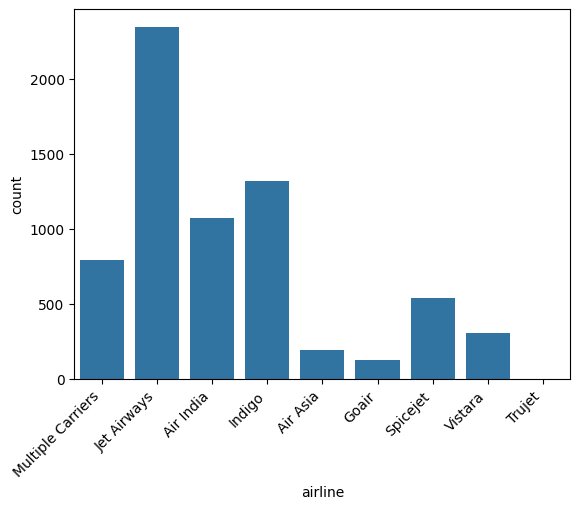

In [15]:
sns.countplot(data = X_train,x = 'airline')
plt.xticks(rotation=45,ha='right')       
plt.show()

In [16]:
# The above graph shows that we have the data of all the jet airways in our training data

# High occurence flight = Multiple Carriers,Jet Airways,Air India,Indigo

<Axes: xlabel='price', ylabel='Density'>

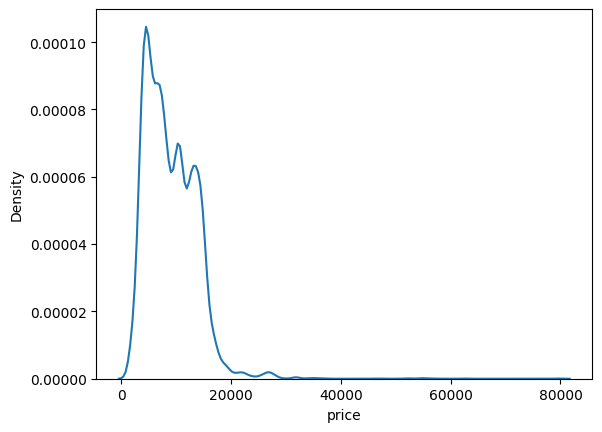

In [17]:
sns.kdeplot(data = flights_cleaned,x = 'price')

In [18]:
row,col = flights_cleaned.query('price < 5000').shape
print("The data points under 5000 are ",row)
row,col = flights_cleaned.query('price > 5000 & price < 10000').shape
print("The data points between 5000 and 10000 are ",row)
row,col = flights_cleaned.query('price > 10000 & price < 20000').shape
print("The data points between 10000 and 20000 are ",row)
row,col = flights_cleaned.query('price > 20000').shape
print("The data points above 20000 are ",row)

The data points under 5000 are  2385
The data points between 5000 and 10000 are  3875
The data points between 10000 and 20000 are  4043
The data points above 20000 are  148


<Axes: xlabel='price'>

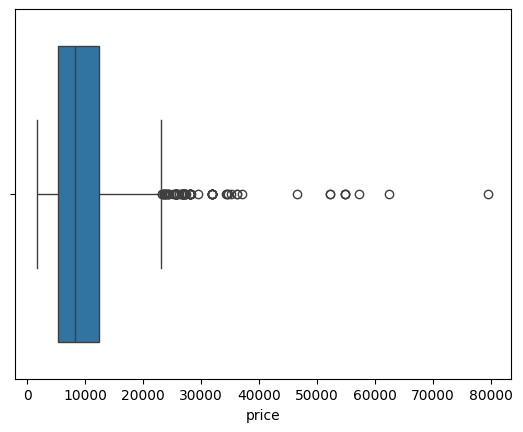

In [19]:
sns.boxplot(data = flights_cleaned,x = 'price')

In [20]:
flights_cleaned.price.describe()

count    10461.000000
mean      9027.212504
std       4624.861032
min       1759.000000
25%       5224.000000
50%       8266.000000
75%      12346.000000
max      79512.000000
Name: price, dtype: float64

In [21]:
flights_cleaned.query('price > 20000 & price < 40000')

,airline,source,destination,duration,total_stops,additional_info,price,dep_time_hour,dep_time_min,dtoj_day,dtoj_month,dtoj_year
7,Jet Airways,banglore,new delhi,1265,1,no info,22270,8,0,1,3,2019
123,Air India,delhi,cochin,1215,1,no info,27430,23,0,1,3,2019
396,Multiple Carriers,delhi,cochin,385,1,no info,36983,12,50,1,3,2019
486,Jet Airways,banglore,new delhi,380,1,no info,26890,8,55,1,3,2019
510,Jet Airways,banglore,new delhi,325,1,no info,26890,7,0,1,3,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
10439,Jet Airways,banglore,new delhi,860,1,no info,31825,18,40,1,3,2019
10456,Jet Airways,delhi,cochin,2860,2,no info,20694,19,10,6,3,2019
10511,Air India,banglore,new delhi,1600,2,2 long layover,26480,6,45,1,3,2019
10561,Jet Airways,banglore,new delhi,1135,1,no info,20800,14,5,1,3,2019
